# Library Importing

In [1]:
# --- SYSTEM & MATH ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

# --- MODELING ---
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# --- DATA HANDLING ---
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# --- CONFIG ---
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
torch.__version__

'2.9.1+cu128'

In [3]:
!nvidia-smi

Wed Dec 31 00:13:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.00                 Driver Version: 577.00         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              2W /  140W |    7777MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data 

In [4]:
def get_datasets(data_root, batch_size=32, img_size=224):
    # Mean and Std for ImageNet (standard for transfer learning)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    data_transforms = {
        'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))
        ], p=0.3),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
        'val': transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'test': transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # Loading from your 'data/processed' directory
    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_root, x), data_transforms[x])
        for x in ['train', 'val', 'test']
    }

    # Create DataLoaders
    loaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=2)
        for x in ['train', 'val', 'test']
    }

    # Class Mapping (Explainability key)
    # This dictionary maps the folder name to the index used by PyTorch
    class_names = image_datasets['train'].classes 
    idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}
    
    return image_datasets, loaders, class_names, idx_to_class

# Initialize
data_path = "../data/processed"
image_datasets, loaders, class_names, idx_to_class = get_datasets(data_path)

print(f"Detected 4 Classes: {class_names}")
print(f"Mapping: {idx_to_class}")

Detected 4 Classes: ['Fair', 'Good', 'Poor', 'Very Poor']
Mapping: {0: 'Fair', 1: 'Good', 2: 'Poor', 3: 'Very Poor'}


# Exploratory Data Analysis


--- Class Distribution Summary ---
Split      test  train  val
Class                      
Fair        103    309  103
Good        169    507  169
Poor         80    237   79
Very Poor    65    190   63

Total Images: 2074


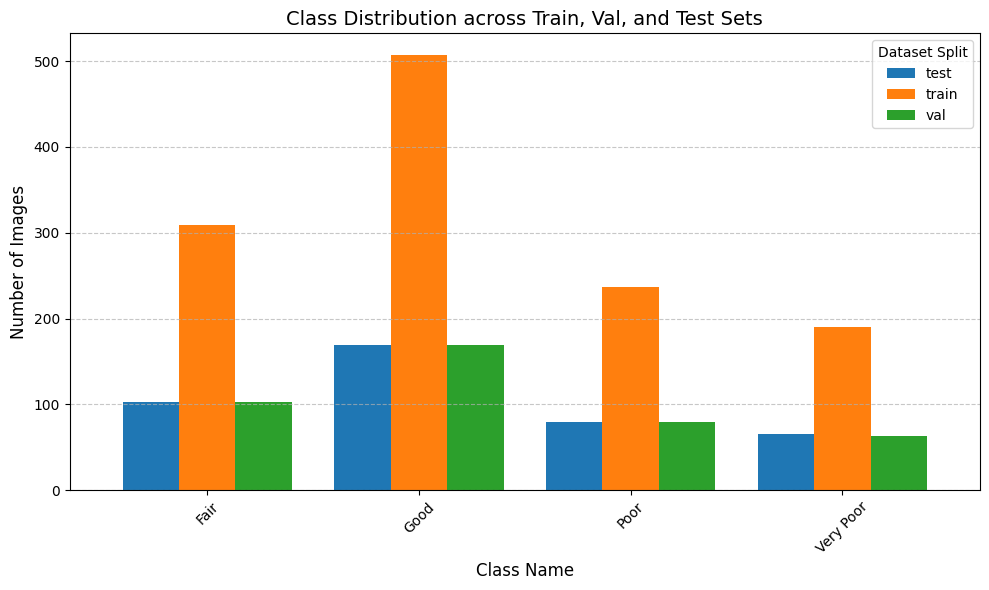

In [5]:
from collections import Counter

def plot_dataset_distributions(image_datasets, class_names):
    data = []
    
    for split in ['train', 'val', 'test']:
        targets = image_datasets[split].targets
        counts = Counter(targets)
        
        for class_idx, count in counts.items():
            data.append({
                'Split': split,
                'Class': class_names[class_idx],
                'Count': count
            })
            
    df = pd.DataFrame(data)
    
    # Pivot for plotting
    pivot_df = df.pivot(index='Class', columns='Split', values='Count').fillna(0)
    
    # Plotting
    ax = pivot_df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Class Distribution across Train, Val, and Test Sets', fontsize=14)
    plt.xlabel('Class Name', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Dataset Split')
    plt.tight_layout()
    
    # Save or show
    plt.savefig('eda/distribution_plot.png')
    
    # Print summary table
    print("\n--- Class Distribution Summary ---")
    print(pivot_df)
    print("\nTotal Images:", pivot_df.sum().sum())

plot_dataset_distributions(image_datasets, class_names)

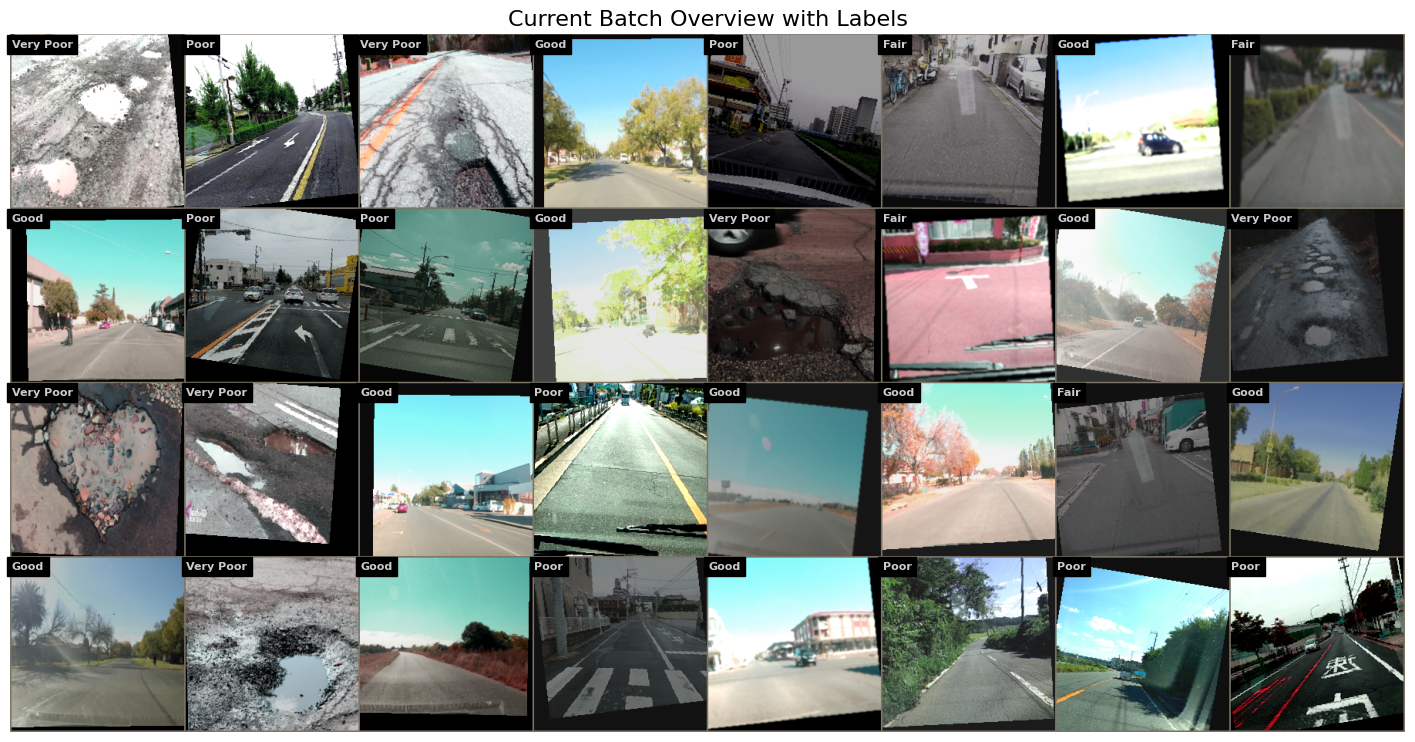

In [6]:
from torchvision.utils import make_grid

def denormalize(tensor):
    """Reverses the ImageNet normalization for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(loader, class_names, nrow=8):
    # Get one batch
    images, labels = next(iter(loader))
    batch_size = images.shape[0]
    
    # Create the grid
    grid = make_grid(images, nrow=nrow, padding=2)
    img_dn = denormalize(grid)
    img_np = img_dn.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(18, 12))
    plt.imshow(img_np)

    img_size = images.shape[2] 
    padding = 2
    
    for i in range(batch_size):
        cols = i % nrow
        rows = i // nrow
        
        x = cols * (img_size + padding) + padding
        y = rows * (img_size + padding) + padding + 15 
        
        plt.text(x, y, class_names[labels[i]], 
                 color='white', backgroundcolor='black', 
                 fontsize=8, weight='bold', alpha=0.8)

    plt.title("Current Batch Overview with Labels", fontsize=16)
    plt.axis('off')
    plt.show()

show_batch(loaders['train'], class_names)

# Model

In [ ]:
class PotholeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    def forward(self, x):
        x = self.backbone(x)
        return x

model = PotholeClassifier(num_classes=len(class_names)).to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training Loop

In [9]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print(f"=> Saving checkpoint to {filename}")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint['epoch'], checkpoint['best_acc']

In [10]:
def predict_with_tta(model, inputs, device):
    model.eval()
    with torch.no_grad():
        # 1. Original Image
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)

        # 2. Horizontal Flip
        flipped_inputs = torch.flip(inputs, dims=[3])
        flipped_probs = F.softmax(model(flipped_inputs), dim=1)

        # 3. Slight Rotation (simulating shakiness)
        # We use a 5-degree rotation as a "safe" TTA
        rotated_inputs = transforms.functional.rotate(inputs, 5)
        rotated_probs = F.softmax(model(rotated_inputs), dim=1)

        # Average the probabilities
        avg_probs = (probs + flipped_probs + rotated_probs) / 3
        
    return avg_probs

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs,device, checkpoint_dir="checkpoints"):
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize history to store metrics for evaluation
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # --- TRAINING PHASE ---
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): 
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Standard loss calculation (usually done on clean images)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # TTA Prediction for Accuracy
                tta_probs = predict_with_tta(model, inputs, device)
                _, preds = torch.max(tta_probs, 1) # Use TTA probabilities for final decision
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = val_running_corrects.double() / len(val_loader.dataset)

        # Store metrics in history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # --- CHECKPOINT LOGIC ---
        is_best = epoch_val_acc > best_acc
        if is_best:
            best_acc = epoch_val_acc
        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_acc': best_acc,
            'history': history 
        }
        
        save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, "last_checkpoint.pth.tar"))
        if is_best:
            save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, "best_model.pth.tar"))

    return model, history

# Evaluation

In [12]:
import torch.nn.functional as F
import cv2

def plot_history(history):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.plot(epochs, history['train_acc'], 'b', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def visualize_gradcam(model, loader, device, class_names, target_layer, num_images=6):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    # Using a dictionary or object to store values is often cleaner than global lists
    results = {'grads': None, 'fmaps': None}

    def backward_hook(module, grad_input, grad_output):
        results['grads'] = grad_output[0].detach() # [B, C, H, W]

    def forward_hook(module, input, output):
        results['fmaps'] = output.detach() # [B, C, H, W]

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_full_backward_hook(backward_hook)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 1. Forward pass for the whole batch to get activations
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            # 2. Backward pass for each image specifically to get specific gradients
            model.zero_grad()
            score = outputs[j, preds[j]]
            score.backward(retain_graph=True)

            # Access the stored tensors
            # results['grads'] shape is [Batch, C, H, W]
            grads_val = results['grads'][j].cpu().numpy()
            fmaps_val = results['fmaps'][j].cpu().numpy()

            # Global Average Pooling across H and W (axis 1 and 2)
            # This works now because grads_val is [C, H, W]
            weights = np.mean(grads_val, axis=(1, 2))
            
            # 3. Weighted sum (CAM)
            cam = np.zeros(fmaps_val.shape[1:], dtype=np.float32)
            for k, w in enumerate(weights):
                cam += w * fmaps_val[k]

            # ReLU and Normalization
            cam = np.maximum(cam, 0)
            cam = cv2.resize(cam, (inputs.shape[3], inputs.shape[2]))
            
            # Avoid division by zero if CAM is all zeros
            denom = (cam.max() - cam.min())
            if denom != 0:
                cam = (cam - cam.min()) / denom

            # 4. Visualization logic
            images_so_far += 1
            ax = plt.subplot((num_images + 2) // 3, 3, images_so_far)
            
            img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
            # If your images are normalized (mean/std), you should un-normalize here
            img = np.clip(img, 0, 1) 
            
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
            
            overlay = heatmap * 0.4 + img * 0.6
            ax.imshow(overlay)
            ax.set_title(f'P: {class_names[preds[j]]}\nA: {class_names[labels[j]]}', 
                         color='green' if preds[j] == labels[j] else 'red')
            ax.axis('off')

            if images_so_far == num_images:
                handle_forward.remove()
                handle_backward.remove()
                plt.tight_layout()
                return

    handle_forward.remove()
    handle_backward.remove()

In [13]:
model, history = train_model(model, loss_fn, optimizer, loaders["train"], loaders["val"], 10,device)
plot_history(history)

Epoch 1/10
----------


KeyboardInterrupt: 

<sys>:0: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000

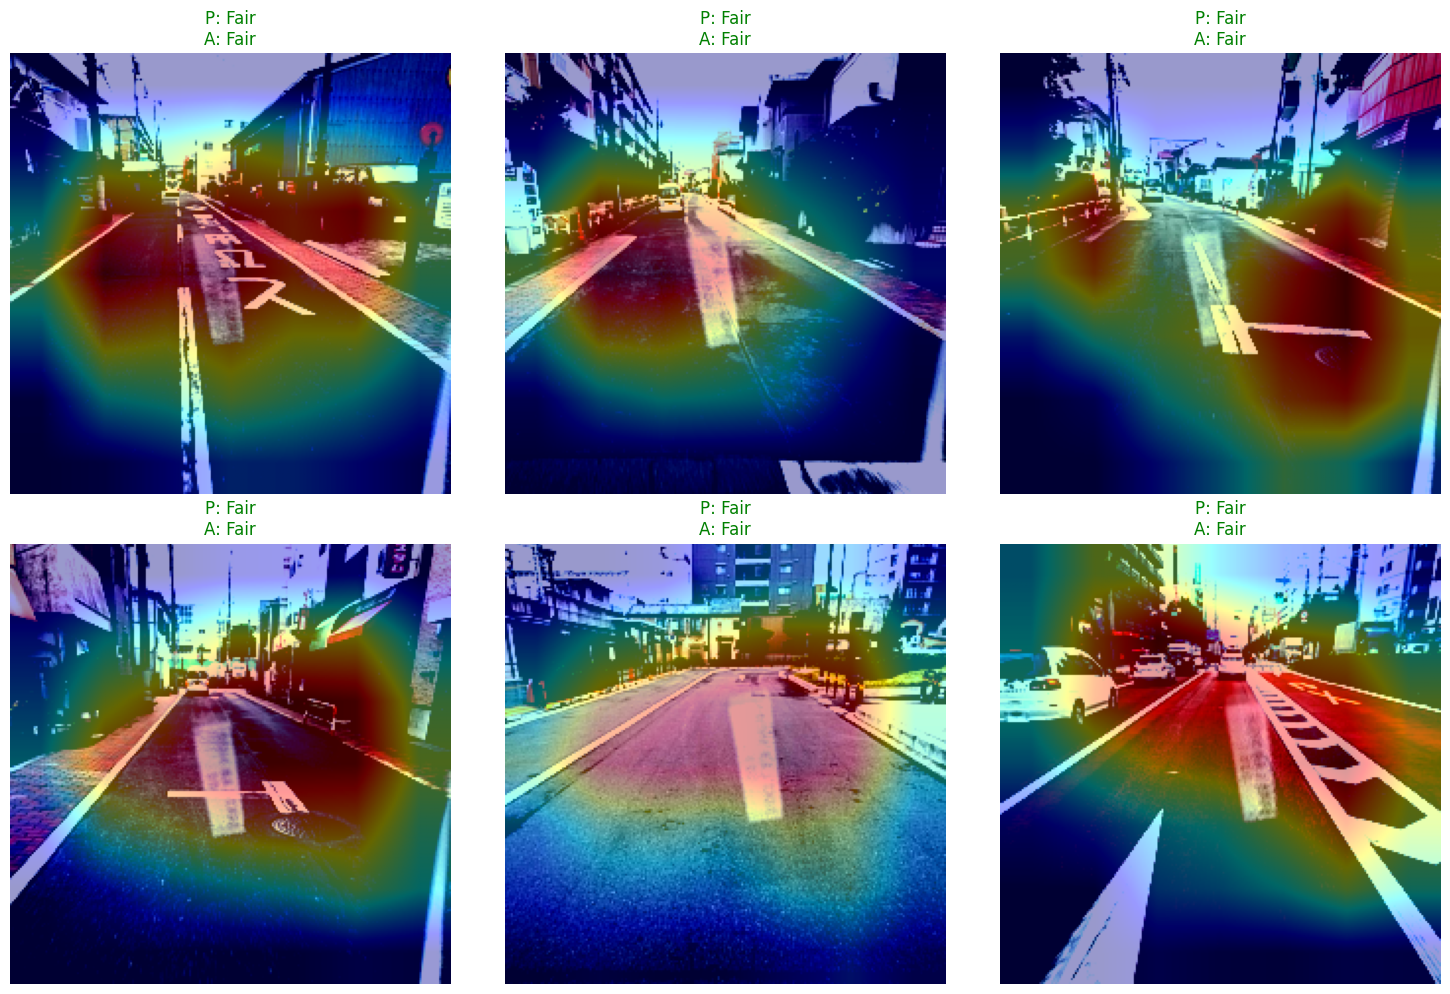

In [ ]:
visualize_gradcam(model, loaders['val'], device, class_names, model.backbone.layer4[1].conv2, num_images=6)

# Testing

In [ ]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    
    # Track per-class accuracy for deeper insight
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'*** FINAL TEST ACCURACY: {total_acc:.4f} ***')
    return all_preds, all_labels
test_model(model,loaders["test"],loss_fn)

*** FINAL TEST ACCURACY: 0.9544 ***


([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64

# Save Model

In [ ]:
save_path = "save_model/resnet18_checkpoint.pth"

# Creating a bundle
checkpoint = {
    'model_name': 'resnet18',
    'state_dict': model.state_dict(),
    'classes': class_names, 
}

torch.save(checkpoint, save_path)
print(f"Model saved to {save_path}")

Model saved to save_model/resnet18_checkpoint.pth
